In [1]:
import os
import random
import logging
from copy import deepcopy
from collections import defaultdict
import matplotlib.pyplot as plt

import cv2
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import wandb
from omegaconf import OmegaConf

from isegm.inference.utils import find_checkpoint_from_training
from isegm.simple_click.utils.log import logger, TqdmToLogger
from isegm.simple_click.utils.vis import draw_probmap, draw_points
from isegm.utils.misc import save_checkpoint
from isegm.simple_click.utils.serialization import get_config_repr
from isegm.simple_click.utils.distributed import (
    get_dp_wrapper,
    get_sampler,
    reduce_loss_dict,
)

from isegm.ritm.inference.iterative_evaluation_training import (
    evaluate_dataset as iterative_evaluate_dataset,
)
from isegm.simple_click.engine.optimizer import get_optimizer, get_optimizer_with_layerwise_decay
from isegm.simple_click.inference.predictors import get_predictor

import torch
from easydict import EasyDict as edict

from isegm.simple_click.model.is_plainvit_model import PlainVitModel
from isegm.simple_click.data.transforms import UniformRandomResize
from isegm.simple_click.data.points_sampler import MultiPointSampler
from isegm.simple_click.model.losses import NormalizedFocalLossSigmoid
from albumentations import *
from functools import partial
from isegm.simple_click.engine.trainer import ISTrainer
from isegm.simple_click.model.modeling.transformer_helper.cross_entropy_loss import (
    CrossEntropyLoss,
)
from omegaconf import OmegaConf
from isegm.data.preprocess import Preprocessor
from isegm.simple_click.inference.utils import get_dataset


from isegm.model.metrics import AdaptiveIoU, F1Score, IoU
# from isegm.simple_click.data.datasets import LidcDataset
from isegm.simple_click.data.datasets import LidcDataset


In [2]:
device = torch.device('cuda:0')

In [3]:
LIDC_PATH = "/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/train"
LIDC_VAL_PATH = "/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/val"
LIDC_CROPS_PATH = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D-128-CROPS/Tr'

In [4]:
import matplotlib.pyplot as plt

def visualise_raw_batch(batch):
    print(batch.keys())
    
    # Determine the number of items in the batch
    batch_size = batch['images'].shape[0]

    # Create a subplot grid with batch_size rows and 2 columns
    fig, axs = plt.subplots(batch_size, 2, figsize=(25, 10 * batch_size), squeeze=False)
    plt.close()

    for i in range(batch_size):
        # Select the ith item from the batch
        image = batch['images'][i, :1, :, :]
        instances = batch['instances'][i, :1, :, :]
        points = batch['points'][i]
        half_point = points.shape[0] // 2
        pos_points = [point for point in points[:half_point] if point[0] != -1]
        neg_points = [point for point in points[half_point:] if point[0] != -1]

        # Image visualization
        axs[i, 0].set_title(f"Image {i}")
        axs[i, 0].imshow(image[0, :, :], cmap='gray')
        axs[i, 0].contour(instances[0, :, :], colors='lime', linewidths=0.5)
        axs[i, 0].scatter([point[1] for point in pos_points], [point[0] for point in pos_points], c='lime', s=5)
        axs[i, 0].scatter([point[1] for point in neg_points], [point[0] for point in neg_points], c='red', s=5)

        # Mask visualization
        axs[i, 1].set_title(f"Mask {i}")
        axs[i, 1].imshow(instances[0, :, :])

    return fig


In [5]:

points_sampler = MultiPointSampler(
        24,
        prob_gamma=0.80,
        merge_objects_prob=0.15,
        max_num_merged_objects=2,
        use_hierarchy=False,
        first_click_center=True,
    )

preprocessor = Preprocessor()
preprocessor.normalize = True
preprocessor.windowing = True
preprocessor.window_min = -900
preprocessor.window_max = 600

train_set = LidcDataset(
    LIDC_PATH, points_sampler=points_sampler, preprocessor=preprocessor
)

val_set = LidcDataset(
    LIDC_VAL_PATH, points_sampler=points_sampler, preprocessor=preprocessor
)

crop_size = (512, 512)

train_augmentator = Compose(
            [
                UniformRandomResize(scale_range=(0.75, 1.40)),
                HorizontalFlip(),
                PadIfNeeded(
                    min_height=crop_size[0], min_width=crop_size[1], border_mode=0
                ),
                RandomCrop(*crop_size),
                # RandomBrightnessContrast(
                #     brightness_limit=(-0.25, 0.25), contrast_limit=(-0.15, 0.4), p=0.75
                # ),
                # RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.75),
            ],
            p=1.0,
        )
val_augmentator = Compose(
            [
                PadIfNeeded(
                    min_height=crop_size[0], min_width=crop_size[1], border_mode=0
                ),
                RandomCrop(*crop_size),
            ],
            p=1.0,
        )

train_set.augmentator = train_augmentator
val_set.augmentator = val_augmentator

In [6]:
train_data = DataLoader(
    train_set,
    1,
    sampler=get_sampler(train_set, shuffle=False, distributed=False),
    drop_last=False,
    pin_memory=True,
    num_workers=0
)
val_data = DataLoader(
    val_set,
    1,
    sampler=get_sampler(val_set, shuffle=False, distributed=False),
    drop_last=False,
    pin_memory=True,
    num_workers=0,
)

In [7]:
train_iter = iter(train_data)
val_iter = iter(val_data)

In [8]:
train_batch = next(train_iter)

In [9]:
val_batch = next(val_iter)
val_batch = next(val_iter)
val_batch = next(val_iter)
val_batch = next(val_iter)

dict_keys(['images', 'points', 'instances'])


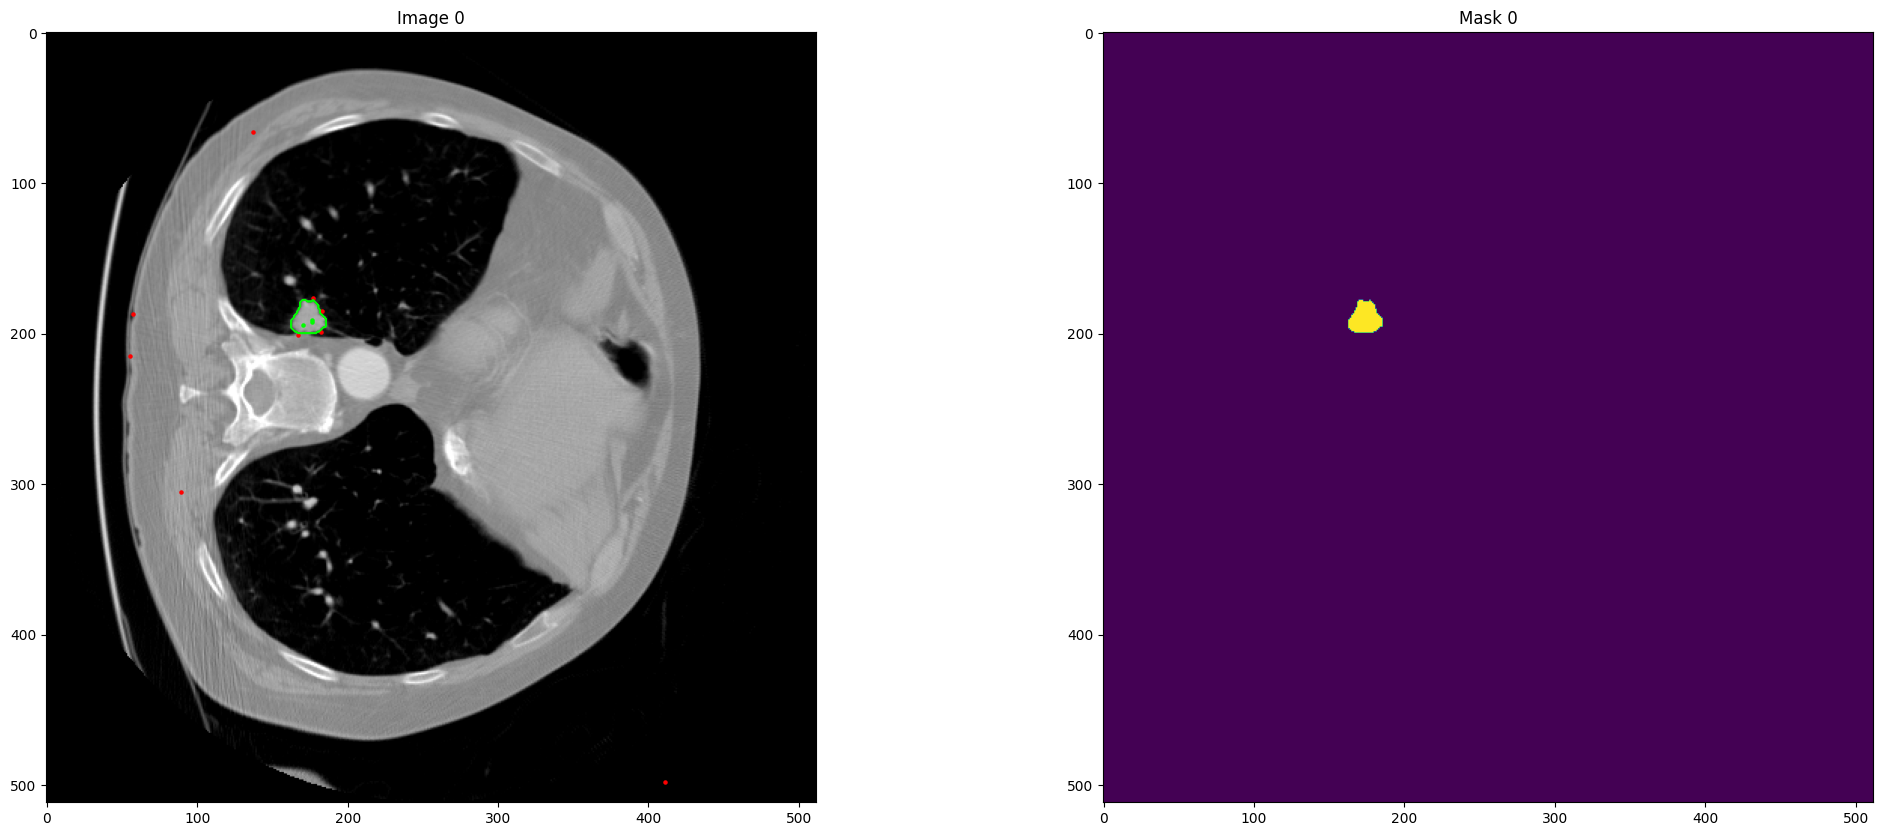

In [10]:
visualise_raw_batch(val_batch)

dict_keys(['images', 'points', 'instances'])


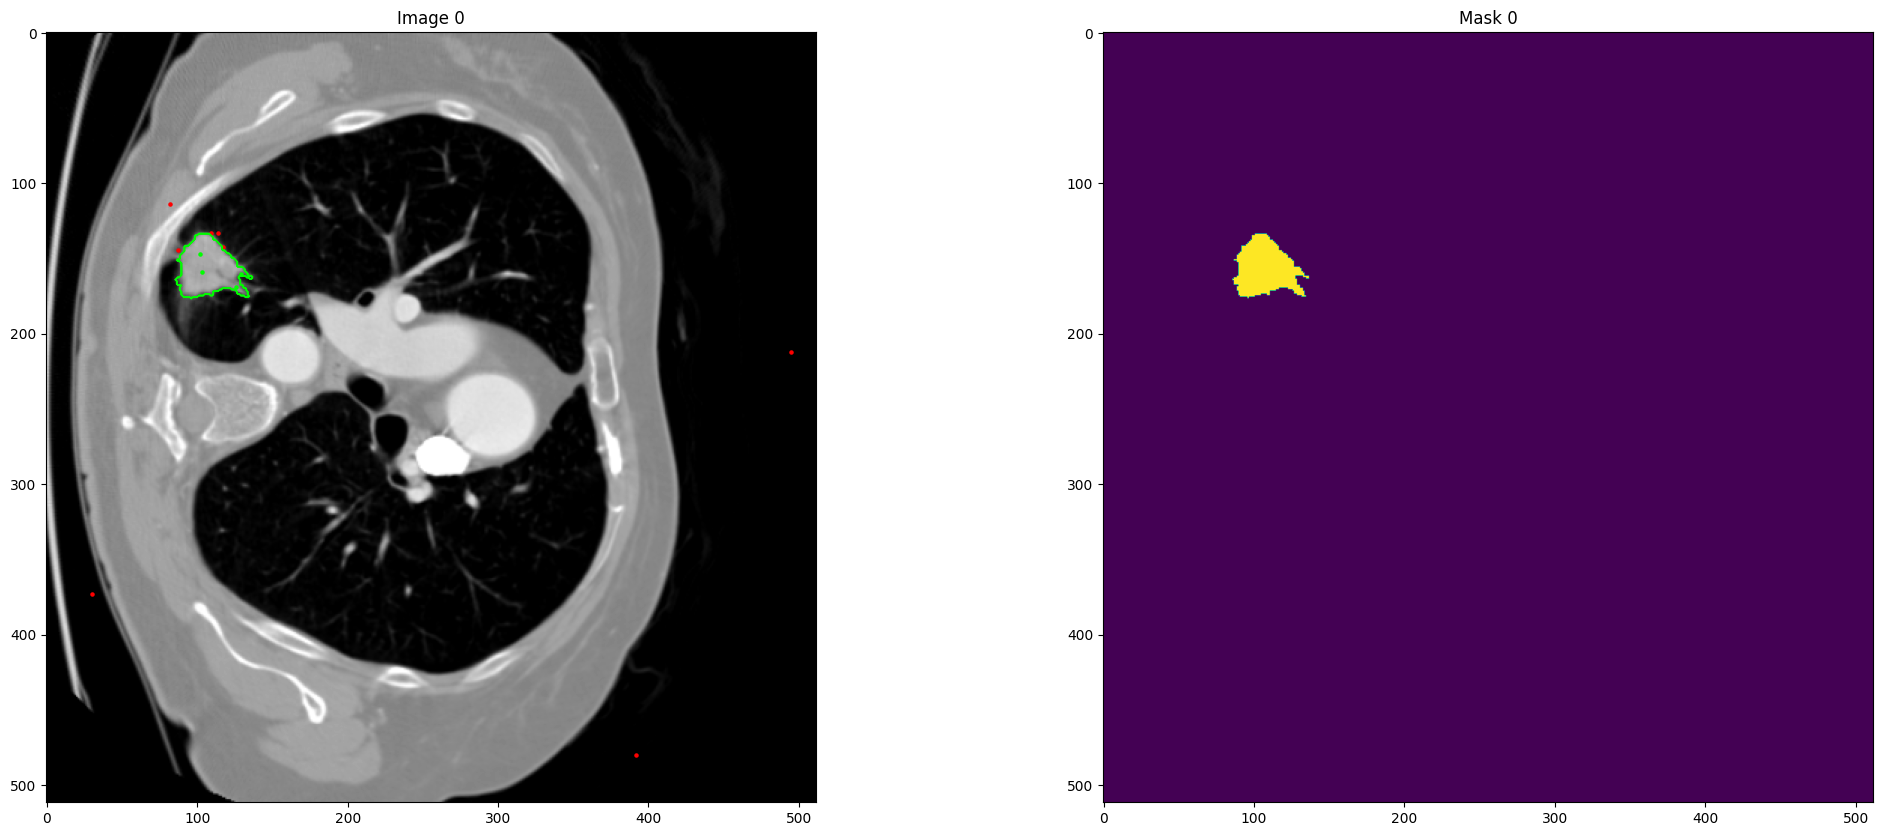

In [11]:
visualise_raw_batch(train_batch)

In [12]:
val_images = val_batch['images']
train_images = train_batch['images']

Text(0.5, 1.0, 'Histogram')

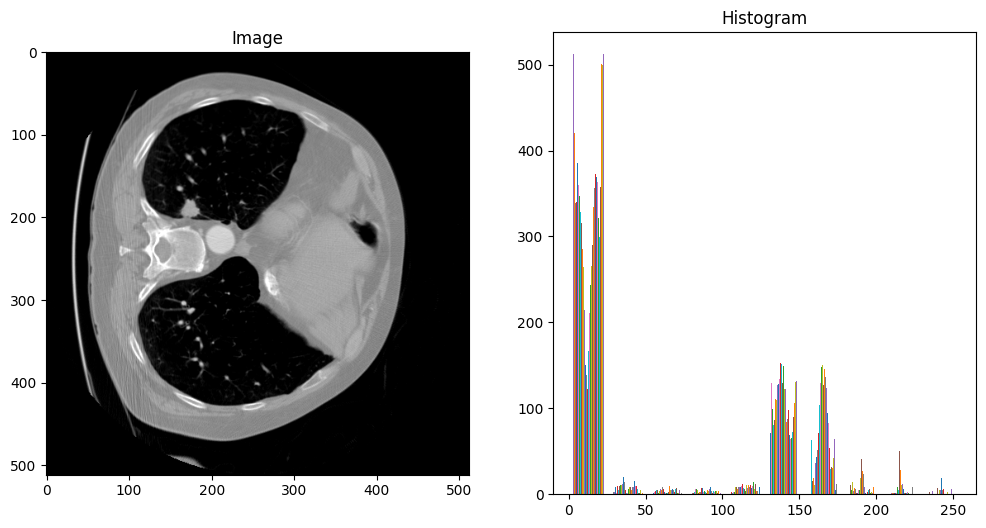

In [13]:
image_data = val_images[0, 0]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the image on the first subplot
axs[0].imshow(image_data, cmap='gray')
axs[0].set_title('Image')

# Display the histogram on the second subplot
axs[1].hist(image_data)
axs[1].set_title('Histogram')

Text(0.5, 1.0, 'Histogram')

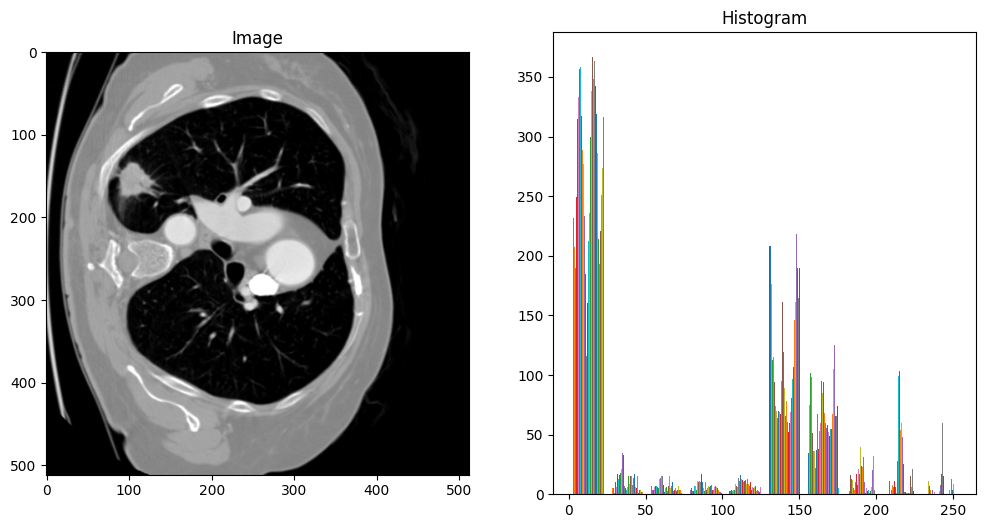

In [14]:
image_data = train_images[0, 0]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the image on the first subplot
axs[0].imshow(image_data, cmap='gray')
axs[0].set_title('Image')

# Display the histogram on the second subplot
axs[1].hist(image_data)
axs[1].set_title('Histogram')

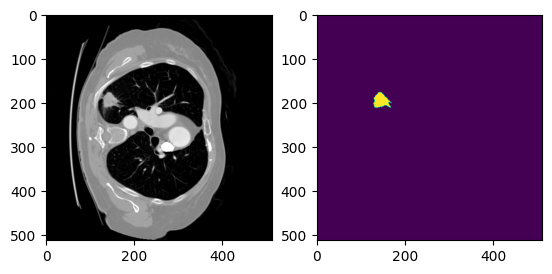

In [15]:
train_sample = train_set.get_sample(0)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_sample.image[:,:,0], cmap='gray')
ax[1].imshow(train_sample.gt_mask)

# Train imitation

In [16]:
loss_cfg = edict()
loss_cfg.instance_loss = NormalizedFocalLossSigmoid(alpha=0.5, gamma=2)
loss_cfg.instance_loss_weight = 1.0

val_loss_cfg = loss_cfg.copy()

In [17]:
def add_loss(loss_name, total_loss, losses_logging, validation, lambda_loss_inputs
    ):
        loss_weight = loss_cfg.get(loss_name + '_weight', 0.0)
        if loss_weight > 0.0:
            loss_criterion = loss_cfg.get(loss_name)
            loss = loss_criterion(*lambda_loss_inputs())
            loss = torch.mean(loss)
            losses_logging[loss_name] = loss
            loss = loss_weight * loss
            total_loss = total_loss + loss

        return total_loss

In [18]:
def get_next_points(pred, gt, points, click_indx, pred_thresh=0.49):
    assert click_indx > 0
    pred = pred.cpu().numpy()[:, 0, :, :]
    gt = gt.cpu().numpy()[:, 0, :, :] > 0.5

    fn_mask = np.logical_and(gt, pred < pred_thresh)
    fp_mask = np.logical_and(np.logical_not(gt), pred > pred_thresh)

    fn_mask = np.pad(fn_mask, ((0, 0), (1, 1), (1, 1)), 'constant').astype(np.uint8)
    fp_mask = np.pad(fp_mask, ((0, 0), (1, 1), (1, 1)), 'constant').astype(np.uint8)
    num_points = points.size(1) // 2
    points = points.clone()

    for bindx in range(fn_mask.shape[0]):
        fn_mask_dt = cv2.distanceTransform(fn_mask[bindx], cv2.DIST_L2, 5)[1:-1, 1:-1]
        fp_mask_dt = cv2.distanceTransform(fp_mask[bindx], cv2.DIST_L2, 5)[1:-1, 1:-1]

        fn_max_dist = np.max(fn_mask_dt)
        fp_max_dist = np.max(fp_mask_dt)

        is_positive = fn_max_dist > fp_max_dist
        dt = fn_mask_dt if is_positive else fp_mask_dt
        inner_mask = dt > max(fn_max_dist, fp_max_dist) / 2.0
        indices = np.argwhere(inner_mask)
        if len(indices) > 0:
            coords = indices[np.random.randint(0, len(indices))]
            if is_positive:
                points[bindx, num_points - click_indx, 0] = float(coords[0])
                points[bindx, num_points - click_indx, 1] = float(coords[1])
                points[bindx, num_points - click_indx, 2] = float(click_indx)
            else:
                points[bindx, 2 * num_points - click_indx, 0] = float(coords[0])
                points[bindx, 2 * num_points - click_indx, 1] = float(coords[1])
                points[bindx, 2 * num_points - click_indx, 2] = float(click_indx)

    return points


In [19]:
from isegm.inference.utils import find_checkpoint, load_is_model
from isegm.utils import exp

device = torch.device('cuda:0')
cfg = exp.load_config_file('config.yml', return_edict=True)

In [20]:
MAX_NUM_NEXT_CLICKS = 3

In [21]:
TRAINING_OUTPUT_PATH = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training'

checkpoint_path = find_checkpoint_from_training(TRAINING_OUTPUT_PATH, 'SimpleClick512_long_run')

model = load_is_model(checkpoint_path, device)
for param in model.parameters():
    param.requires_grad = True
model = model.to(device)
model.train()

click_models = None
prev_mask_drop_prob = 0.0

model_class: None


In [22]:
def batch_forward(batch_data, validation=False):
        losses_logging = dict()

        with torch.set_grad_enabled(not validation):
            batch_data = {k: v.to(device) for k, v in batch_data.items()}
            image, gt_mask, points = (
                batch_data['images'],
                batch_data['instances'],
                batch_data['points'],
            )
            orig_image, orig_gt_mask, orig_points = (
                image.clone(),
                gt_mask.clone(),
                points.clone(),
            )

            prev_output = torch.zeros_like(image, dtype=torch.float32)[:, :1, :, :]

            last_click_indx = None

            min_num_iters = 0

            with torch.no_grad():
                num_iters = random.randint(min_num_iters, MAX_NUM_NEXT_CLICKS)
                print(f'num_iters: {num_iters}')
                inference_info = []

                for click_indx in range(num_iters):
                    last_click_indx = click_indx

                    if not validation:
                        model.eval()

                    if click_models is None or click_indx >= len(
                        click_models
                    ):
                        eval_model = model
                    else:
                        eval_model = click_models[click_indx]

                    net_input = (
                        torch.cat((image, prev_output), dim=1)
                        if model.with_prev_mask
                        else image
                    )
                    
                    prev_mask = prev_output.cpu().clone()
                    
                    prev_output = torch.sigmoid(
                        eval_model(net_input, points)['instances']
                    )
                    
                    inference_info.append({
                        'image': image.cpu(),
                        'prev_mask': prev_mask.cpu(),
                        'points': points.cpu(),
                        'output': prev_output
                    })

                    points = get_next_points(
                        prev_output, orig_gt_mask, points, click_indx + 1
                    )

                    if not validation:
                        model.train()

                if (
                    model.with_prev_mask
                    and prev_mask_drop_prob > 0
                    and last_click_indx is not None
                ):
                    zero_mask = (
                        np.random.random(size=prev_output.size(0))
                        < prev_mask_drop_prob
                    )
                    prev_output[zero_mask] = torch.zeros_like(prev_output[zero_mask])

            batch_data['points'] = points

            net_input = (
                torch.cat((image, prev_output), dim=1)
                if model.with_prev_mask
                else image
            )
            output = model(net_input, points)
            
            info = {
            }
            
            info['coarse_pass'] = {
                'inference_info': inference_info,
                'image': image.cpu(),
                'prev_mask': prev_output.cpu(),
                'points': points.cpu(),
                'output': output
            }

            loss = 0.0
            loss = add_loss(
                'instance_loss',
                loss,
                losses_logging,
                validation,
                lambda: (output['instances'], batch_data['instances']),
            )
            loss = add_loss(
                'instance_aux_loss',
                loss,
                losses_logging,
                validation,
                lambda: (output['instances_aux'], batch_data['instances']),
            )

            # if self.is_master:
            #     with torch.no_grad():
            #         for m in metrics:
            #             m.update(
            #                 *(output.get(x) for x in m.pred_outputs),
            #                 *(batch_data[x] for x in m.gt_outputs),
            #             )
        return loss, losses_logging, batch_data, output, info

In [32]:
loss, losses_logging, batch_data, output, run_info = batch_forward(val_batch)

num_iters: 2


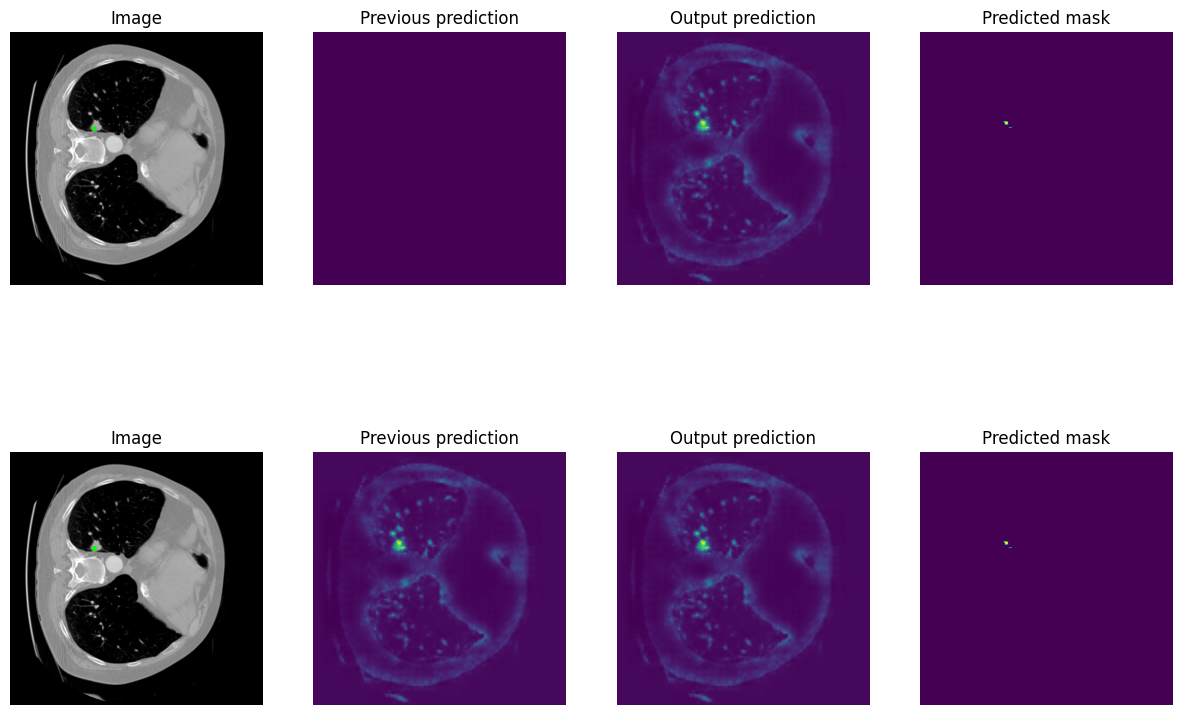

In [33]:
def visualise_coarse_iterations(info, indx=0):
    
    points = info['coarse_pass']['points'][indx].cpu().numpy()
    half_point = points.shape[0] // 2
    pos_points = points[:half_point]
    neg_points = points[half_point:]
    pos_points = [[point[0], point[1], point[2], True] for point in pos_points if point[0] != -1 and point[2] != 100]
    neg_points = [[point[0], point[1], point[2], False] for point in neg_points if point[0] != -1 and point[2] != 100]
    points = pos_points + neg_points
    points.sort(key=lambda x: x[2])
        
    info = info['coarse_pass']['inference_info']
    
    fig, ax = plt.subplots(len(info), 4, figsize=(15, 10), squeeze=False)
    plt.close()
    
    for i, inf in enumerate(info):
        
        ax[i, 0].set_title("Image")
        ax[i, 0].imshow(inf['image'][indx, 0, :, :].cpu(), cmap='gray')
        ax[i, 0].axis('off')

        ax[i, 0].scatter([point[1] for point in points[:i+1] if point[3] == True], [point[0] for point in points[:i+1] if point[3] == True], c='lime', s=5)
        ax[i, 0].scatter([point[1] for point in points[:i+1] if point[3] == False], [point[0] for point in points[:i+1] if point[3] == False], c='red', s=5)

        ax[i,1].set_title("Previous prediction")
        ax[i,1].imshow(inf['prev_mask'][indx, 0, :, :].cpu())
        ax[i,1].axis('off')

        ax[i,2].set_title("Output prediction")
        ax[i,2].imshow(inf['output'][indx, 0, :, :].cpu().detach())
        ax[i,2].axis('off')
        
        ax[i,3].set_title('Predicted mask')
        ax[i,3].imshow(inf['output'][indx, 0, :, :].cpu().detach() > 0.5)
        ax[i,3].axis('off')
        
    return fig
    
visualise_coarse_iterations(run_info, indx=0)    

dict_keys(['inference_info', 'image', 'prev_mask', 'points', 'output'])
dict_keys(['instances', 'instances_aux'])
[[194.0, 170.0, 0.0, True], [194.0, 170.0, 1.0, True], [192.0, 170.0, 2.0, True], [192.0, 176.0, 100.0, True], [191.0, 176.0, 100.0, True], [176.0, 177.0, 100.0, False], [187.0, 57.0, 100.0, False], [66.0, 137.0, 100.0, False], [199.0, 182.0, 100.0, False], [498.0, 411.0, 100.0, False], [305.0, 89.0, 100.0, False], [185.0, 183.0, 100.0, False], [201.0, 167.0, 100.0, False], [215.0, 55.0, 100.0, False]]


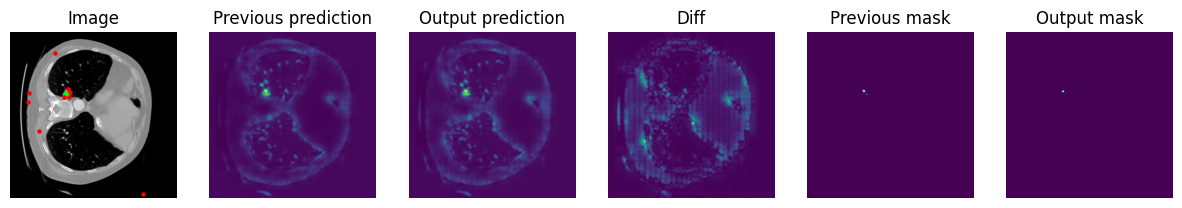

In [53]:
def visualise_coarse(info, indx=0):
    info = info['coarse_pass']
    print(info.keys())
    print(info['output'].keys())
    
    fig, ax = plt.subplots(1, 6, figsize=(15, 10))
    
    ax[0].set_title("Image")
    ax[0].imshow(info['image'][indx, 0, :, :].cpu(), cmap='gray')
    ax[0].axis('off')
    
    points = info['points'][indx].cpu().numpy()
    half_point = points.shape[0] // 2
    pos_points = points[:half_point]
    neg_points = points[half_point:]
    pos_points = [[point[0], point[1], point[2], True] for point in pos_points if point[0] != -1]
    neg_points = [[point[0], point[1], point[2], False] for point in neg_points if point[0] != -1]
    # pos_points = [[point[0], point[1], point[2], True] for point in pos_points if point[0] != -1 and point[2] != 100]
    # neg_points = [[point[0], point[1], point[2], False] for point in neg_points if point[0] != -1 and point[2] != 100]
    points = pos_points + neg_points
    points.sort(key=lambda x: x[2])
    # points = points[:len(info['inference_info'])]
    
    ax[0].scatter([point[1] for point in points if point[3] == True], [point[0] for point in points if point[3] == True], c='lime', s=5)
    ax[0].scatter([point[1] for point in points if point[3] == False], [point[0] for point in points if point[3] == False], c='red', s=5)
    print(points)
    
    ax[1].set_title("Previous prediction")
    ax[1].imshow(info['prev_mask'][indx, 0, :, :].cpu())
    ax[1].axis('off')
    
    ax[2].set_title("Output prediction")
    ax[2].imshow(torch.sigmoid(info['output']['instances'][indx, 0, :, :].cpu().detach()))
    ax[2].axis('off')
    
    ax[3].set_title('Diff')
    ax[3].imshow(np.abs(info['prev_mask'][indx, 0, :, :].cpu() - torch.sigmoid(info['output']['instances'][indx, 0, :, :].cpu().detach())))
    ax[3].axis('off')
    
    ax[4].set_title("Previous mask")
    ax[4].imshow(info['prev_mask'][indx, 0, :, :].cpu() > 0.5)
    ax[4].axis('off')
    
    ax[5].set_title("Output mask")
    ax[5].imshow(torch.sigmoid(info['output']['instances'][indx, 0, :, :].cpu().detach()) > 0.5)
    ax[5].axis('off')
    
visualise_coarse(run_info, indx=0)    